# Policy Gradient with and without Baseline

In [1]:
import gymnasium as gym
import ale_py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

## Code for training 

### CartPole-v1

In [ ]:
# --- Device Setup ---
gpu_id = 2
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Helper: Compute Returns ---
def compute_returns_cp(rewards, gamma=0.95, device=device):
    """Compute discounted returns for one episode, GPU-compatible."""
    returns = torch.zeros(len(rewards), dtype=torch.float32, device=device)
    G = 0.0
    for i in reversed(range(len(rewards))):
        G = rewards[i] + gamma * G
        returns[i] = G
    return returns


# --- Policy Network ---
class PolicyMLP(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        return self.net(x)


# --- Value Network ---
class ValueMLP(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        return self.net(x).squeeze(-1)


# --- Training Function (no vectorization, no entropy) ---
def train_cartpole(use_baseline=True, num_episodes=1000, gamma=0.95, lr=0.001,
                   batch_size=8, early_stop_threshold=None):
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = PolicyMLP(state_dim, action_dim).to(device)
    value_fn = ValueMLP(state_dim).to(device) if use_baseline else None

    optimizer_policy = optim.Adam(policy.parameters(), lr=lr)
    optimizer_value = optim.Adam(value_fn.parameters(), lr=lr) if use_baseline else None

    episode_rewards = []
    batch_states, batch_log_probs, batch_returns = [], [], []

    with tqdm(total=num_episodes, desc="Training CartPole", ncols=100) as pbar:
        for episode in range(num_episodes):
            state, _ = env.reset()
            log_probs, rewards, states = [], [], []
            done = False

            while not done:
                state_t = torch.tensor(state, dtype=torch.float32).to(device)
                probs = policy(state_t)
                dist = Categorical(probs)
                action = dist.sample()

                next_state, reward, done, _, _ = env.step(action.item())
                log_probs.append(dist.log_prob(action))
                rewards.append(reward)
                states.append(state_t)
                state = next_state

            returns = compute_returns_cp(rewards, gamma=gamma, device=device)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            batch_states.extend(states)
            batch_log_probs.extend(log_probs)
            batch_returns.extend(returns)

            episode_rewards.append(sum(rewards))

            # Update policy/value every batch_size episodes
            if (episode + 1) % batch_size == 0 or episode == num_episodes - 1:
                states_tensor = torch.stack(batch_states)
                log_probs_tensor = torch.stack(batch_log_probs)
                returns_tensor = torch.tensor(batch_returns, dtype=torch.float32, device=device)

                if use_baseline:
                    values = value_fn(states_tensor)
                    advantage = returns_tensor - values.detach()
                    policy_loss = -torch.sum(log_probs_tensor * advantage)
                    value_loss = 0.5 * torch.sum((returns_tensor - values) ** 2)

                    optimizer_policy.zero_grad()
                    policy_loss.backward()
                    optimizer_policy.step()

                    optimizer_value.zero_grad()
                    value_loss.backward()
                    optimizer_value.step()
                else:
                    policy_loss = -torch.sum(log_probs_tensor * returns_tensor)
                    optimizer_policy.zero_grad()
                    policy_loss.backward()
                    optimizer_policy.step()

                batch_states, batch_log_probs, batch_returns = [], [], []

            if (episode + 1) % 100 == 0:
                mean_last50 = np.mean(episode_rewards[-50:]) if episode_rewards else 0
                tqdm.write(f"Episode {episode+1}, mean reward (last 50): {mean_last50:.2f}")

            if early_stop_threshold is not None and len(episode_rewards) >= 100:
                if np.mean(episode_rewards[-100:]) >= early_stop_threshold:
                    tqdm.write(f"\nEarly stopping at episode {episode+1}")
                    break

            pbar.update(1)

    env.close()
    return policy, episode_rewards


# --- Evaluation Function ---
def evaluate_cartpole(policy, episode_rewards=None, n_eval_episodes=500):
    env = gym.make("CartPole-v1")

    if episode_rewards is not None:
        plt.figure(figsize=(10,5))
        plt.plot(episode_rewards, alpha=0.5, label="Episode Reward")
        ma = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
        plt.plot(range(99, len(episode_rewards)), ma, label="Moving Average (100)")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("CartPole-v1 Training Rewards")
        plt.legend()
        plt.show()

    eval_rewards = []

    with torch.no_grad(), tqdm(total=n_eval_episodes, desc="Evaluating Policy", ncols=100) as pbar:
        for _ in range(n_eval_episodes):
            state, _ = env.reset()
            obs, _, _, _, _ = env.step(1)
            done = False
            total_reward = 0

            while not done:
                state_t = torch.tensor(state, dtype=torch.float32).to(device)
                probs = policy(state_t)
                action = torch.argmax(probs).item()
                state, reward, done, _, _ = env.step(action)
                total_reward += reward

            eval_rewards.append(total_reward)
            pbar.update(1)

    env.close()

    plt.figure(figsize=(8,5))
    plt.hist(eval_rewards, bins=20, alpha=0.7)
    plt.xlabel("Episode Reward")
    plt.ylabel("Count")
    plt.title("CartPole-v1 Evaluation Rewards")
    plt.show()

    print(f"Mean Reward: {np.mean(eval_rewards):.2f}, Std: {np.std(eval_rewards):.2f}")
    return eval_rewards


Using device: cuda:2


### Pong-v5

In [2]:
# Device setup
gpu_id = 3
if torch.cuda.is_available():
    device = torch.device(f"cuda:{gpu_id}" if gpu_id is not None else "cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


# Utility functions
def preprocess(image):
    # Same as your original (fast and proven)
    image = image[35:195]
    image = image[::2, ::2, 0]
    image[image == 144] = 0
    image[image == 109] = 0
    image[image != 0] = 1
    return image.astype(np.float32)

def compute_returns_pg(rewards, gamma=0.99, device=device):
    T = len(rewards)
    returns = torch.zeros(T, dtype=torch.float32, device=device)
    G = 0.0
    for t in range(T - 1, -1, -1):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns


# Architectures
class CNNBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU()
        )
        # infer flattened size with a dummy pass
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 80, 80)
            conv_out = self.conv(dummy)
            self.flattened_size = conv_out.numel() // conv_out.shape[0]
        self.flatten = nn.Flatten()
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return x

class PolicyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = CNNBase()
        self.fc = nn.Sequential(
            nn.Linear(self.base.flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Softmax(dim=-1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.fc:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        return self.fc(self.base(x))

class ValueCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = CNNBase()
        self.fc = nn.Sequential(
            nn.Linear(self.base.flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.fc:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        return self.fc(self.base(x)).squeeze(-1)

# Training
def train_pong(
    use_baseline=True,
    num_episodes=2000,
    gamma=0.99,
    lr=1e-4,
    batch_size=4,          
    clip_grad_norm=5.0,
    max_steps=10000, 
    early_stop_threshold=16
):
    env = gym.make("ALE/Pong-v5")
    policy = PolicyCNN().to(device)
    optimizer_policy = optim.Adam(policy.parameters(), lr=lr)

    value_fn, optimizer_value = None, None
    if use_baseline:
        value_fn = ValueCNN().to(device)
        optimizer_value = optim.Adam(value_fn.parameters(), lr=lr)

    episode_rewards = []

    batch_log_probs = []
    batch_states_for_value = []
    batch_returns = []

    with tqdm(total=num_episodes, desc="Training Pong-v5", ncols=110) as pbar:
        for ep in range(num_episodes):
            obs, _ = env.reset()
            obs, _, _, _, _ = env.step(1)
            prev_frame = None
            ep_log_probs = []
            ep_states = []
            ep_rewards = []
            steps = 0
            done = False

            while not done:
                # Preprocess and frame difference
                cur_frame = preprocess(obs)
                x_np = cur_frame - prev_frame if prev_frame is not None else np.zeros((80, 80), dtype=np.float32)
                prev_frame = cur_frame

                # (1,1,80,80) on device
                x = torch.tensor(x_np, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

                # Forward policy, sample action
                probs = policy(x).squeeze(0)   # (2,)
                dist = Categorical(probs)
                action = dist.sample()
                pong_action = 2 + action.item()  # map {0,1} -> {2,3}

                # Step
                obs, reward, done, _, _ = env.step(pong_action)
                ep_log_probs.append(dist.log_prob(action))
                ep_states.append(x.detach())  # value net doesn't need policy graph
                ep_rewards.append(reward)

                steps += 1
                if steps >= max_steps:
                    done = True  # early truncation

            # episode done: returns and logging
            ep_returns = compute_returns_pg(ep_rewards, gamma=gamma, device=device)
            episode_rewards.append(sum(ep_rewards))

            # accumulate to batch
            batch_log_probs.extend(ep_log_probs)
            batch_states_for_value.extend(ep_states)
            batch_returns.extend(ep_returns)

            # progress bar info
            if (ep + 1) % 10 == 0:
                last10 = episode_rewards[-10:]
                pbar.set_postfix({
                    "avg_reward(10)": f"{np.mean(last10):.2f}",
                    "steps(ep)": steps
                })

            # optimization step every batch_size episodes (or at the end)
            do_update = ((ep + 1) % batch_size == 0) or (ep + 1 == num_episodes)
            if do_update:
                # Stack tensors
                log_probs_t = torch.stack(batch_log_probs)                        
                states_t = torch.cat(batch_states_for_value, dim=0)                      
                returns_t = torch.stack(batch_returns).to(device) if isinstance(batch_returns[0], torch.Tensor) \
                            else torch.tensor(batch_returns, dtype=torch.float32, device=device)

                # Normalize returns across the whole batch to reduce variance
                returns_t = (returns_t - returns_t.mean()) / (returns_t.std() + 1e-8)

                if use_baseline:
                    values = value_fn(states_t)
                    advantage = returns_t - values.detach()
                    policy_loss = -(log_probs_t * advantage).sum()

                    value_loss = 0.5 * ((returns_t - values) ** 2).sum()

                    optimizer_policy.zero_grad()
                    policy_loss.backward()
                    torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=clip_grad_norm)
                    optimizer_policy.step()

                    optimizer_value.zero_grad()
                    value_loss.backward()
                    torch.nn.utils.clip_grad_norm_(value_fn.parameters(), max_norm=clip_grad_norm)
                    optimizer_value.step()
                else:
                    policy_loss = -(log_probs_t * returns_t).sum()
                    optimizer_policy.zero_grad()
                    policy_loss.backward()
                    torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=clip_grad_norm)
                    optimizer_policy.step()

                # clear batch buffers
                batch_log_probs.clear()
                batch_states_for_value.clear()
                batch_returns.clear()

            # early stopping on moving average of last 100 episodes
            if len(episode_rewards) >= 100:
                if np.mean(episode_rewards[-100:]) >= 18:
                    print(f"\nEarly stopping at episode {ep+1}")
                    break

            pbar.update(1)

    env.close()
    return policy, episode_rewards


# Evaluation
def evaluate_pong(policy, episode_rewards=None, n_eval_episodes=100):
    env = gym.make("ALE/Pong-v5")
    eval_rewards = []

    if episode_rewards is not None:
        plt.figure(figsize=(10,5))
        plt.plot(episode_rewards, alpha=0.5, label="Episode Reward")
        if len(episode_rewards) >= 100:
            ma = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
            plt.plot(range(99, len(episode_rewards)), ma, label="Moving Average (100)")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Pong-v5 Training Rewards")
        plt.legend()
        plt.show()

    with torch.no_grad(), tqdm(total=n_eval_episodes, desc="Evaluating Pong-v5", ncols=110) as pbar:
        for _ in range(n_eval_episodes):
            obs, _ = env.reset()
            prev_frame = None
            total_reward = 0
            done = False

            while not done:
                cur_frame = preprocess(obs)
                x_np = cur_frame - prev_frame if prev_frame is not None else np.zeros((80,80), dtype=np.float32)
                prev_frame = cur_frame

                x = torch.tensor(x_np, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
                probs = policy(x).squeeze(0)
                action = torch.argmax(probs).item()
                pong_action = 2 + action

                obs, reward, done, _, _ = env.step(pong_action)
                total_reward += reward

            eval_rewards.append(total_reward)
            pbar.set_postfix({"avg_reward": f"{np.mean(eval_rewards):.2f}"})
            pbar.update(1)

    env.close()

    plt.figure(figsize=(8,5))
    plt.hist(eval_rewards, bins=20, alpha=0.7)
    plt.xlabel("Episode Reward")
    plt.ylabel("Count")
    plt.title("Pong-v5 Evaluation Rewards")
    plt.show()

    print(f"Mean Reward: {np.mean(eval_rewards):.2f}, Std: {np.std(eval_rewards):.2f}")
    return eval_rewards


Using device: cuda:3


## Part 1

### Cartpole-v1

Training CartPole:   0%|                                                   | 0/1000 [00:00<?, ?it/s]

Training CartPole:  10%|████▏                                    | 103/1000 [00:02<00:24, 37.04it/s]

Episode 100, mean reward (last 50): 19.62


Training CartPole:  20%|████████▎                                | 202/1000 [00:06<00:34, 23.40it/s]

Episode 200, mean reward (last 50): 27.40


Training CartPole:  30%|████████████▍                            | 302/1000 [00:12<00:41, 16.77it/s]

Episode 300, mean reward (last 50): 46.18


Training CartPole:  40%|████████████████▌                        | 403/1000 [00:19<00:40, 14.64it/s]

Episode 400, mean reward (last 50): 47.48


Training CartPole:  50%|████████████████████▌                    | 501/1000 [00:26<00:37, 13.20it/s]

Episode 500, mean reward (last 50): 58.10


Training CartPole:  60%|████████████████████████▋                | 601/1000 [00:37<01:07,  5.92it/s]

Episode 600, mean reward (last 50): 79.16


Training CartPole:  70%|████████████████████████████▋            | 701/1000 [00:55<00:51,  5.77it/s]

Episode 700, mean reward (last 50): 147.64


Training CartPole:  80%|████████████████████████████████▉        | 802/1000 [01:21<01:00,  3.27it/s]

Episode 800, mean reward (last 50): 181.20


Training CartPole:  87%|███████████████████████████████████▌     | 866/1000 [01:39<00:15,  8.70it/s]



Early stopping at episode 867


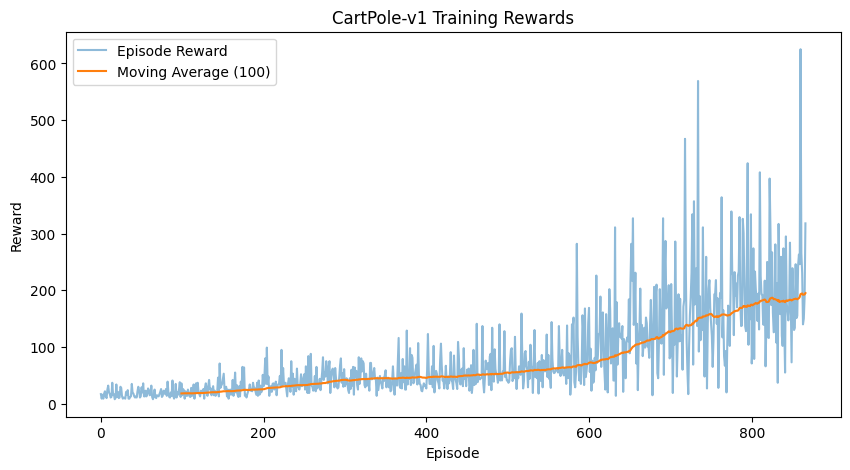

Evaluating Policy: 100%|██████████████████████████████████████████| 500/500 [01:42<00:00,  4.87it/s]


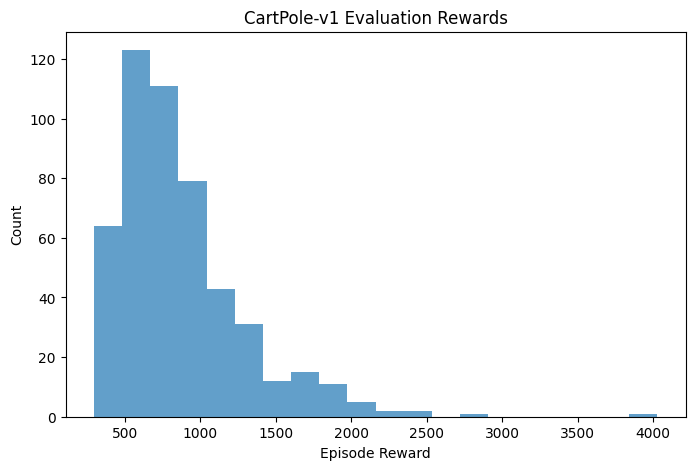

Mean Reward: 867.86, Std: 425.14


In [8]:
policy_cp_n, rewards_cp_n = train_cartpole(use_baseline=False, early_stop_threshold=195)
eval_rewards_cp_n = evaluate_cartpole(policy_cp_n, episode_rewards=rewards_cp_n, n_eval_episodes=500)

### Pong-v5

In [ ]:
policy_pg_n, rewards_pg_n = train_pong(use_baseline=False, num_episodes=1500)
eval_rewards_pg_n = evaluate_pong(policy_pg_n, episode_rewards=rewards_pg_n, n_eval_episodes=500)

Training Pong-v5:  15%|██            | 223/1500 [09:50<57:30,  2.70s/it, avg_reward(10)=-20.20, steps(ep)=945]

## Part 2

### Cartpole-v1

Training CartPole:  11%|████▍                                    | 107/1000 [00:02<00:20, 43.83it/s]

Episode 100, mean reward (last 50): 14.76


Training CartPole:  21%|████████▍                                | 206/1000 [00:04<00:19, 40.78it/s]

Episode 200, mean reward (last 50): 17.68


Training CartPole:  30%|████████████▌                            | 305/1000 [00:07<00:23, 29.54it/s]

Episode 300, mean reward (last 50): 22.14


Training CartPole:  40%|████████████████▍                        | 402/1000 [00:12<00:34, 17.16it/s]

Episode 400, mean reward (last 50): 32.76


Training CartPole:  50%|████████████████████▌                    | 502/1000 [00:20<00:38, 12.84it/s]

Episode 500, mean reward (last 50): 65.18


Training CartPole:  60%|████████████████████████▋                | 601/1000 [00:30<00:54,  7.37it/s]

Episode 600, mean reward (last 50): 74.54


Training CartPole:  70%|████████████████████████████▋            | 701/1000 [00:45<00:44,  6.78it/s]

Episode 700, mean reward (last 50): 112.98


Training CartPole:  80%|████████████████████████████████▊        | 800/1000 [01:09<00:56,  3.57it/s]

Episode 800, mean reward (last 50): 169.18


Training CartPole:  85%|██████████████████████████████████▊      | 848/1000 [01:24<00:15,  9.99it/s]


Early stopping at episode 849


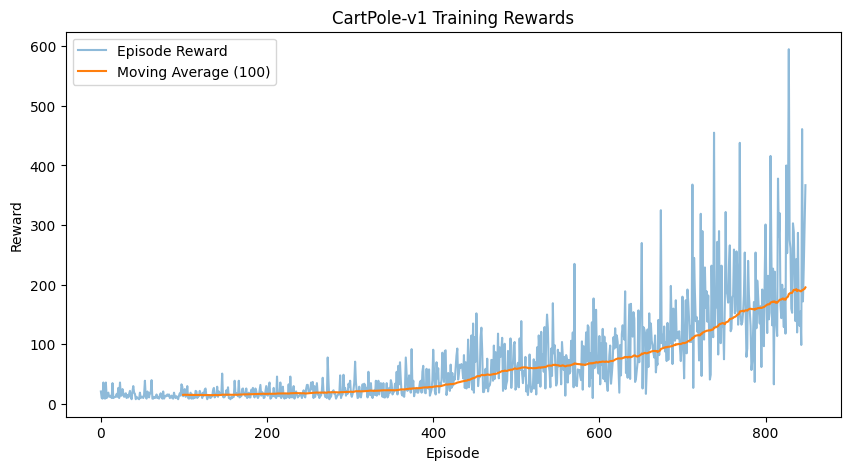

Evaluating Policy: 100%|██████████████████████████████████████████| 500/500 [03:18<00:00,  2.52it/s]


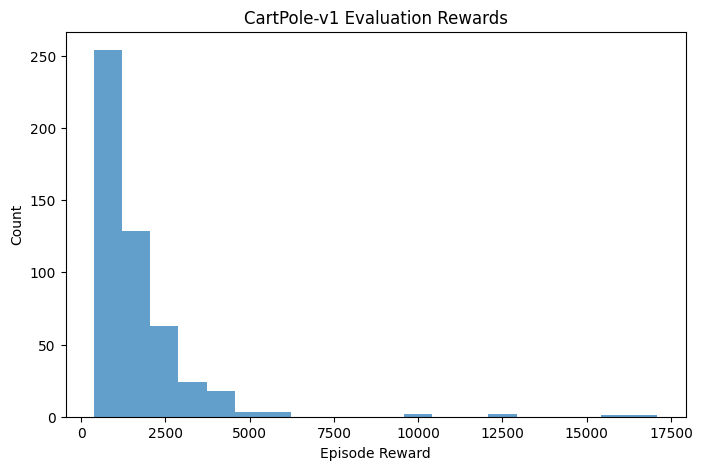

Mean Reward: 1673.76, Std: 1594.63


In [10]:
policy_cp_y, rewards_cp_y = train_cartpole(use_baseline=True, early_stop_threshold=195)
eval_rewards_cp_y = evaluate_cartpole(policy_cp_y, episode_rewards=rewards_cp_y, n_eval_episodes=500)

### Pong-v5

In [ ]:
policy_pg_y, rewards_pg_y = train_pong(use_baseline=True, num_episodes=1500)
eval_rewards_pg_y = evaluate_pong(policy_pg_y, episode_rewards=rewards_pg_y, n_eval_episodes=500)